In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta  
import threading
import os

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.
Executed query and closed connection.


In [3]:
def add_missing_dates(old_dates):
    start_date = dates[0]
    end_date = dates[-1]
    all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
    return [(date.date()) for date in all_dates]
    
def add_missing_counts(old_counts, old_dates, new_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(new_dates))
        for i, date in enumerate(new_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts

In [4]:
all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

In [5]:
def plot_estimates_flat(number_of_queries, N, model, epsilon, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    return answers

In [6]:
def plot_estimates_hh_degree(number_of_queries, N, model, epsilon, degree, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, degree, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N}, B = {degree} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    return answers

In [7]:
def plot_estimates_hh_degree_mutiplee_qurries(queries, N, model, epsilon, degree, dates, counts):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(len(queries))
    
    current_model = model(epsilon, degree, test_dates, test_counts)
    correct_answers = np.zeros(len(queries))

    for i in range(0, len(queries)):
        answer = current_model.answer(queries[0])
        answers[i] = answer
        correct_answers[i] = current_model.real_answer(queries[0])
    
    """
    print(answers)
    
    x = np.arange(0,len(queries))
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N}, B = {degree} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    """
    return answers, correct_answers

4
106.31972169301491
1444.0
[1242.]
[725. 295. 178.]
[203. 173. 176. 160.  90.  98.  91. 117.  87.]
[48. 65. 39. 46. 53. 45. 54. 60. 49. 43. 47. 35. 35. 38. 43. 37. 38. 50.
 31. 55. 34. 43. 35. 31. 47. 34. 39.]
[22. 15.  9. 19. 14. 15. 18. 11. 17. 16. 12. 16. 21. 11. 15. 27. 20. 13.
 16. 18. 19. 17. 16. 18. 21. 14. 16. 23. 13. 18. 15. 17. 22. 18. 21. 17.
 18. 15. 17. 10. 12. 10. 19. 11. 15. 15. 13. 11. 11. 15. 19. 16. 15. 19.
 11. 17. 20. 18. 15. 11. 17. 22. 16. 14. 17. 12. 21. 16. 18. 11. 14.  8.
 13. 12. 16. 14.  9. 14.  7. 20. 18.]
[1998.32990489  867.67724367 2124.00878575  567.70178555 2362.40293071
 -152.27186514 1715.25907552  985.00882633  766.286673    815.67035445
  541.07237746 1257.94514552 1860.17954949  202.47991186 1652.62760066
 2594.90816246 -174.27462083   34.45304387 2447.02269388 1196.91151798
 1806.44512523 1268.84564073 1127.99586646 1811.8912393  1584.96594287
 2539.11475018  180.67272113 1705.81227253 1712.91591085 2107.46247797
 2531.79694599 2120.98824774 1821

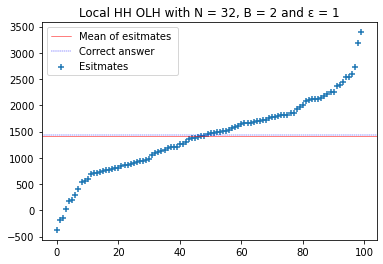

[ 1.15010835e+02 -5.03187516e+02  7.77899726e+02  2.59118589e+03
  9.85695803e+02  5.25809544e+02  3.57601278e+03  1.67632640e+03
 -4.59925442e+02  1.77092635e+03 -3.78773091e+02  9.69593471e+02
  1.62575240e+03  3.43496334e+03  3.59783768e+03  9.61703195e+02
  1.96808248e+03 -9.37969874e+01  2.91874717e+03  2.08172867e+03
  1.24067626e+03  1.95894130e+03  1.30546609e+03  2.09739761e+03
  4.06358163e+02  5.71354551e+02  1.10951159e+03  2.45828691e+03
  7.69972492e+02  1.48286574e+03  1.79295781e+03 -2.29255761e+02
  2.21796364e+03  1.29539579e+03 -3.71052412e+02  1.27257582e+03
 -1.07909175e+02  7.91033513e+02  8.96970210e+01  9.28907859e+02
  5.67952614e+02  7.99906543e+02  1.71153731e+03  8.85034829e+02
  2.81539337e+02  2.73310648e+03 -4.17093149e+02 -1.35025964e+03
  1.72731351e+03  1.24586614e+03  1.13953623e+03  6.45545749e+02
  1.49887313e+03  3.68276377e+03  8.65959599e+02  1.65738742e+03
  2.97093155e+03  2.68739187e+03  8.85586684e-01  1.00730618e+03
  2.07089449e+03  1.26918

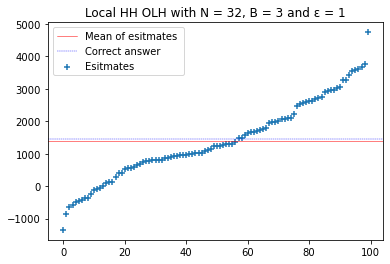

[ 1580.02669774  2792.64103863   321.75069907  2054.86364182
  2225.37782957  2286.21589216  1874.42290946  3765.21197739
  2118.8781092   1120.36615846   547.72064581  2344.98049935
   208.63328229  2682.83247006  1335.4390546   1520.15914115
  1551.74734355  3416.33051267  -335.73287617  1672.32051932
  2119.9810586   2235.17193077  -197.6449534   1677.70282291
  2617.58260987  3030.61098537  1502.77683756  1400.68891479
  3045.78739017   959.64607191  2194.89257658  2209.09847538
 -1336.45072571  1797.43793609  -173.77739681  1063.80745007
  2966.46407459  1747.3644807    625.94101198    77.16305592
   207.6627763   2444.86252332  1844.07009988  4501.75398139
   -19.54256325   286.98609188  1763.6438349    735.74958056
   205.45687749   947.64607191   727.05842876  1146.43961385
  1638.65886153   272.78019307  4195.35776967  2966.46407459
   215.25097869   636.83806258  1384.40956059  1825.58484688
  2234.06898137    82.67780293  3534.69778964   521.64719041
  1393.10071239  3710.72

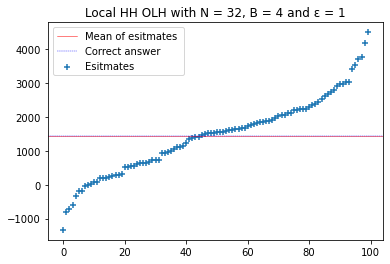

array([-1336.45072571,  -794.29046606,  -712.62880827,  -606.12908789,
        -335.73287617,  -197.6449534 ,  -173.77739681,   -43.41011985,
         -19.54256325,    21.83974034,    77.16305592,    82.67780293,
         205.45687749,   207.6627763 ,   208.63328229,   215.25097869,
         266.42738349,   272.78019307,   286.98609188,   321.75069907,
         521.64719041,   530.33834221,   547.72064581,   551.02949401,
         596.6911518 ,   625.94101198,   636.83806258,   641.11741678,
         671.60266977,   727.05842876,   728.16137816,   735.74958056,
         921.57261651,   947.64607191,   959.64607191,   994.27823569,
        1063.80745007,  1120.36615846,  1121.46910786,  1146.43961385,
        1242.04228363,  1335.4390546 ,  1384.40956059,  1393.10071239,
        1400.68891479,  1477.80633157,  1502.77683756,  1520.15914115,
        1520.29158456,  1534.36503995,  1551.74734355,  1564.71784954,
        1569.12964715,  1580.02669774,  1621.27655793,  1625.55591213,
      

In [12]:
class HH_OLH:
    def __init__(self, epsilon, degree, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:
            #print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.degree = degree
        self.h = int(np.ceil(np.log(len(self.all_dates)) / np.log(degree)))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = old_dates[0]
        end_date = old_dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.all_dates))
        for i, date in enumerate(self.all_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(self.degree**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            idxs = self.get_index(index,self.h)
            idxs.reverse()
            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (self.degree**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        idx = []
        for i in np.arange(0,self.h):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//self.degree))
        idx.append(0)
        return idx
    
    def get_group(self, idx, level):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 0 index

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        if level == 0:
            return id
        elif idx == 0:
            return np.arange(0,self.degree)
        else:
            group_index = idx //self.degree
            level_indicis = np.arange(0,self.degree**level)

            split_ratio = (len(level_indicis) // self.degree)
            level_indicis_split = np.array_split(level_indicis, split_ratio)
            
            return level_indicis_split[group_index]
    
    def OLH_func(self, x, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            return x
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count - (1-p)*N/g) / (p)
    
    def turns_right(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]

            if nxt == 0:
                #We went left
                direction_lst.append(0)

            elif nxt == current*self.degree + self.degree - 1:
                #We went right
                direction_lst.append(1)

            else: 
                direction_lst.append(0)
            
        return direction_lst


    def turns_left(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]

            #Checks
            if nxt == 0:
                #We went left
                direction_lst.append(1)
            #Checks
            elif current == 0 and current < nxt:
                #We went right
                direction_lst.append(0)
            elif nxt == self.degree * current:
                #We went left
                direction_lst.append(1)
            else:
                #We went right
                direction_lst.append(0)
            
        return direction_lst
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]
        

        idx_left = idx_0-1
        idx_right = idx_1+1
        
        path_to_left = np.flip(np.array(self.get_index(idx_left,self.h+1)))
        path_to_right = np.flip(np.array(self.get_index(idx_right,self.h+1)))
        
        turns_left_lst = self.turns_left(path_to_right)
        turns_right_lst = self.turns_right(path_to_left)

        range_count = 0.0
        
        if idx_0 == 0 and idx_1 == np.max(np.fromiter(self.idx_dict.values(), dtype = int)):
            node = self.tree_levels[0]
            range_count = self.OLH_aggre(node, np.sum(self.tree_levels[0]), 1) 
        
        elif idx_0 == 0:

            level_offset = 1

            for i in range(len(turns_left_lst)):

                if turns_left_lst[i] == 0:
                    group = self.get_group(path_to_right[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]

                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    
                    for node in count_nodes:
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
    
        elif idx_1 == np.max(np.fromiter(self.idx_dict.values(), dtype = int)):
            
            level_offset = 1
            
            for i in range(len(turns_right_lst)):
                if turns_right_lst[i] == 0:

                    group = self.get_group(path_to_left[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_left[i+level_offset])[0][0]

                    count_nodes = self.tree_levels[i+level_offset][group[idx_sss+1:]]
                    for node in count_nodes:
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                    
                    
        else:
            
            level_offset = 1
            left_count = []
            left_count_group = []

            for i in range(len(turns_left_lst)):
                if turns_left_lst[i] == 0:
                    group = self.get_group(path_to_right[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]

                    left_count_group.append(group[:idx_sss]) 

                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    left_count.append(count_nodes)

                else:
                    left_count_group.append(np.array([]))
                    left_count.append(np.array([]))

            #The search right side
            right_count = []
            right_count_group = []

            for i in range(len(turns_right_lst)):
                if turns_right_lst[i] == 0:

                    group = self.get_group(path_to_left[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_left[i+level_offset])[0][0]

                    right_count_group.append(group[idx_sss+1:]) 

                    count_nodes = self.tree_levels[i+level_offset][group[idx_sss+1:]]
                    right_count.append(count_nodes)

                else:
                    right_count_group.append(np.array([]))
                    right_count.append(np.array([]))
            
            for i in range(len(left_count_group)):

                if left_count_group[i].size != 0 and right_count_group[i].size != 0:
                    #Both not zero
                    group_left = self.get_group(left_count_group[i][0], i+ level_offset)
                    group_right = self.get_group(right_count_group[i][0], i+ level_offset)

                    if not (np.array_equal(group_left,group_right)):
                        for node in left_count_group[i]:
                            range_count = range_count + self.OLH_aggre(self.tree_levels[i+level_offset][node], np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                        
                        for node in right_count_group[i]:
                            range_count = range_count + self.OLH_aggre(self.tree_levels[i+level_offset][node], np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))

                    else:
                        count_nodes = np.intersect1d(left_count_group[i], right_count_group[i])
                        for node in count_nodes:
                            range_count = range_count + self.OLH_aggre(self.tree_levels[i+level_offset][node], np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))

                if left_count_group[i].size != 0 and right_count_group[i].size == 0:
                    #Left not zero
                    for node in left_count_group[i]:
                        if path_to_left[i] != path_to_right[i]:
                            range_count = range_count + self.OLH_aggre(self.tree_levels[i+level_offset][node], np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))

                if right_count_group[i].size != 0 and left_count_group[i].size == 0:
                    #Right not zero
                    for node in right_count_group[i]:
                        if path_to_left[i] != path_to_right[i]:
                            range_count = range_count + self.OLH_aggre(self.tree_levels[i+level_offset][node], np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))

        return range_count * (self.h+1)
    
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 
        

#query_dates = ('2014-01-27','2014-02-01')
query_dates = ('2014-01-27','2014-02-01')
epsilon = 1
degree = 3
local_HH = HH_OLH(epsilon, degree, all_dates[:32], all_counts[:32])
print(local_HH.h)
#date_obj_0 = datetime.strptime('2014-01-27','%Y-%m-%d').date()
#date_obj_1 = datetime.strptime('2014-02-01','%Y-%m-%d').date()
#print(local_HH.idx_dict[date_obj_0])
#print(local_HH.idx_dict[date_obj_1])
#local_HH.tree_levels = [np.arange(0,1), np.arange(0,2), np.arange(0,4), np.arange(0,8),np.arange(0,16),np.arange(0,32)]
print(local_HH.answer(query_dates))
print(local_HH.real_answer(query_dates))
#print(local_HH.degree)
for level in local_HH.tree_levels:
    print(level)

degree = 2    
number_of_queries = 100 
N = 32
plot_estimates_hh_degree(number_of_queries, N, HH_OLH, epsilon, degree, all_dates, all_counts, query_dates, '1234.png')
degree = 3    
number_of_queries = 100 
N = 32
plot_estimates_hh_degree(number_of_queries, N, HH_OLH, epsilon, degree, all_dates, all_counts, query_dates, '1234.png')
degree =4    
number_of_queries = 100 
N = 32
plot_estimates_hh_degree(number_of_queries, N, HH_OLH, epsilon, degree, all_dates, all_counts, query_dates, '1234.png')